# Project: Parking slot occupancy on CNRPARK dataset
I divided this project into two main parts: parking slot detection and parking slot occupancy. As it can be seen in the code, for the former part I suggested also a method I did not use in the following of the work, which is how to find parking slots inside of an image without any further information. Thanks to the characteristics of the dataset, I could make use of 9 csv files, corresponding to the 9 cameras of the dataset, to provide me with the coordinates of the parking slots. However, as it can also be seen from the few images printed with the parking slots already detected, the information given cover just some parking slots and it is not always satisfactory. Nonetheless, the results achieved are nice and useful.
As mentioned above, I also added some methods that would be necessary if I had no prior information regarding the parking slots (I am referring to the csv files): in this case I would need to evaluate at least one image per camera, apply gaussian blurring to reduce noise, edge detection with Canny and use the Hough transform to find the parking slots. Anyway, it can be seen that by following this approach the results are not satisfactory and I would have had to manually create a mask for each camera to adjust what I had achieved with this approach. Considering that following this approach would have taken much longer, with similar results regardless, I opted to exploit the information given in the dataset.

### First part: parking slots detection

In [1]:
from pathlib import Path
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def drawLines(img: np.ndarray, lines: np.ndarray):
    '''
    This method has the purpose of drawing the lines of the parking slots. It needs an image and an array of 4 points: the former 2 are the 
    coordinates (x,y) on the 2592x1944 format image and the latter two are respectively the width and the height of each parking slot. As it can 
    be seen from the result image, the rectangles obtained through this method do not correspond exactly to the parking slots and do not even take 
    into account all the parking slots inside of the image, however this is due to the dataset given by the project.
    It returns the image with the parking slots highlighted.
    '''
    new_img = np.copy(img)
    new_img = cv.resize(new_img, (2592,1944)) #Rescaling to draw the lines right.
    for i in range(len(lines)):
        if(len(lines[i])==4):
            x=lines[i, 0]
            y=lines[i, 1]
            cv.line(new_img, (x,y), (x+lines[i, 2],y), (255,255,255), 5)
            cv.line(new_img, (x,y), (x,y+lines[i, 3]), (255,255,255), 5)
            cv.line(new_img, (x+lines[i, 2],y), (x+lines[i, 2],y+lines[i, 3]), (255,255,255), 5)
            cv.line(new_img, (x,y+lines[i, 3]), (x+lines[i, 2],y+lines[i, 3]), (255,255,255), 5)
        if(len(lines[i])!=4):
            print("The format in input as regards the lines is not conform to the one expected, which is 4 points (corresponding respectively to the \
            coordinates (x,y) and the width and height of the parking slot).")
    new_img = cv.resize(new_img, (1000,750)) #Convert back to the 1000x750 format.
    new_img = cv.resize(new_img, (0,0), fx=0.7, fy=0.7) #Convert to a format which makes it easier to see all the parking spots.
    return new_img

In [3]:
import os
import glob
from PIL import Image

def img_list(images_path: str):
    '''
    This method takes in input the path to the images and returns them in an array. It was first thought and created to store the images in the folders
    OVERCAST, RAINY and SUNNY of the dataset into three different folders. Once the images are inside of the array, it is easier and faster to access 
    them. This method is strictly linked with the drawLines one, as it makes use of it in order to draw the rectangles on the images and save them in 
    the array with the geometric forms over them. WARNING: the code can be slow!
    '''
    try:
        temp_folders = os.listdir(images_path)
        temp_images = []
        for folder_name, _, files in os.walk(images_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                    image_path = os.path.join(folder_name, file)
                    image = Image.open(image_path)
                    image = drawLines(image, np.array(df[int(folder_name[-1:])-1].iloc[:, 1:])) #I can just take the last 1 symbol to acknowledge the camera
                    temp_images.append(image)
        return temp_images
    except:
        print("The user input does not match with the expected one. Please modify it and try again.")

In [4]:
# First part: Download datasets and extract the information needed
from pathlib import Path
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image

root_directory = Path("./data_project/CNR-EXT_FULL_IMAGE_1000x750")
csv_files = root_directory.glob("*.csv")
df = []
for csv_file in csv_files:
    df.append(pd.read_csv(str(csv_file))) #I save every dataframe in the list df: here I will have all the information presented in the csv files.    
# The coordinates for the lines refer to the image in the 2592x1944 format and need to be rescaled to match the 1000x750 format.
# The following code draws the lines of the parking slots on top of the image.
img_example = cv.imread("./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera1/2015-11-16_0710.jpg")
lines = np.array(df[0].iloc[:, 1:])
img_example = drawLines(img_example, lines)
cv.imshow("Example1", img_example)
cv.waitKey(0)
cv.destroyAllWindows()
img_example2 = cv.imread("./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera1/2015-11-16_0740.jpg")
img_example2 = drawLines(img_example2, lines)
cv.imshow("Example2", img_example2)
cv.waitKey(0)
cv.destroyAllWindows()

# Define the path to the folder containing the images
overcast_path = "./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/"
overcast_images = img_list(overcast_path)
rainy_path = "./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/RAINY/"
rainy_images = img_list(rainy_path)
sunny_path = "./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/SUNNY/"
sunny_images = img_list(sunny_path)

In [5]:
%matplotlib inline
def show_img(img, title=None):
    # Check if the image is in BGR format and convert it to RGB
    rgb_control = Image.fromarray(img)
    if len(img.shape) == 3 and img.shape[2] == 3 and rgb_control.mode == 'BGR':
        try:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        except:
            'Impossible to convert the image from BGR to RGB.'
    
    # Plot the image
    plt.figure() 
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

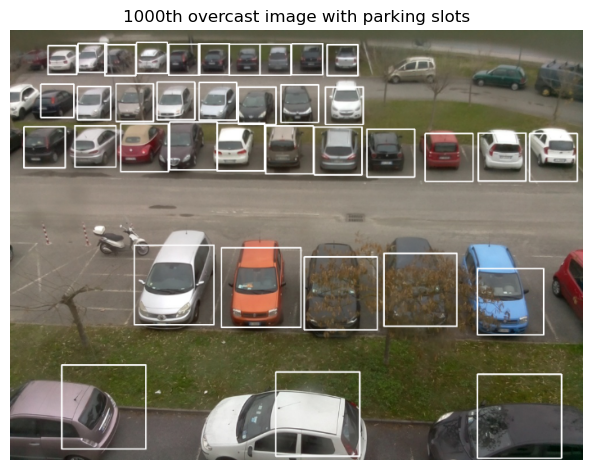

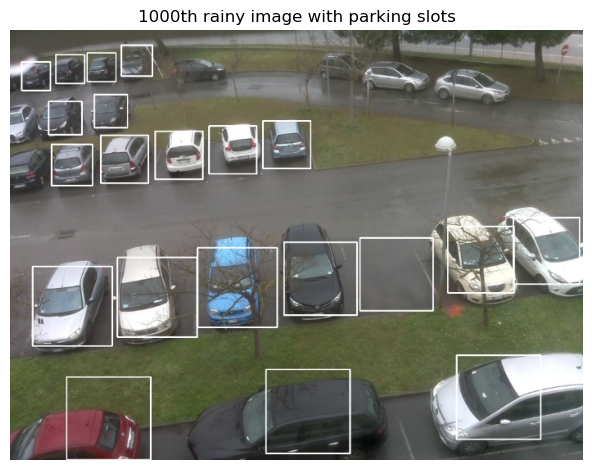

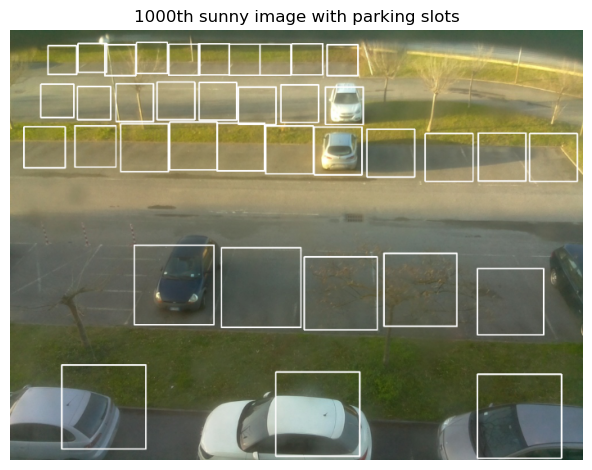

In [6]:
# Printing the 1000th image to make sure everything is fine in the array of images
show_img(overcast_images[1000], "1000th overcast image with parking slots")
show_img(rainy_images[1000], "1000th rainy image with parking slots")
show_img(sunny_images[1000], "1000th sunny image with parking slots")

#### Alternative method:
If there was no prior information regarding the position of the parking slots, I would have needed to compute these methods and manually correct with the use of masks the positions of the parking slots. This procedure would have to be done for all the 9 cameras in the dataset. By running the 2 cells below I am able to retrieve a rough understanding of where are the parking spaces and from there I would need to manually adjust the position of the parking slots detected.

In [165]:
def detect_edges(img, low_threshold=50, high_threshold=200): # Low and high thresholds found manually by computing many times the method.
    img=cv.GaussianBlur(img,(1,1),0)
    return cv.Canny(img, low_threshold, high_threshold)
    
original = cv.imread("./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera1/2015-11-16_0710.jpg")
img=original.copy()
edges = detect_edges(original)
cv.imshow("Edges", edges)
cv.waitKey(0)
cv.destroyAllWindows()

In [172]:
def hough_lines(image): # Image should be the output of the Canny detection.
    edges = detect_edges(image)
    lines = cv.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    cv.imshow('Detected lines', image)
    cv.waitKey(0)
    cv.destroyAllWindows()
original = cv.imread("./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera1/2015-11-16_0710.jpg")
hough = hough_lines(original)

## TO DO NOW: DETECTION OF THE PARKING SPACES TO SEE IF THEY ARE FREE OR BUSY
Now that I have created the array for all the images with the rectangles given from the csv file, I can inspect each image inside of the rectangles to see wheter the parking spaces are free or not. What I am trying to do, and have done in the code above, is obtaining  images of the parking slots just like the ones contained in the 'patches', which contains just the small pictures inside of the rectangles for each image. The images contained in this folder will be of great use, as they are divided into two folders: busy and free. By exploiting this given ground truth we can build a ML model, or we can use other methods to determine the level of accuracy of our prediction. Some useful methods we can inspect can be: \
-Machine learning applied on the histograms of the images\
-SIFT or ORB with bag of visual words

### First approach: directly using Machine Learning
For the first method I am going to explore, I will directly use machine learning with binary classification on the patches, which are the images cropped to fit inside of the rectangular slots of the parking spaces, divided into the folders 'busy' and 'free'. Usually, this approach is discouraged, as data inside of the folders can be inaccurate and could contain some false positive or false negative that will bring noise to the machine learning model. Regardless, as a first approach to the task, it can be interesting to look at the results and compare them later on with other more advanced approaches.

In [7]:
import os
import glob
from PIL import Image

def img_list_without_lines(images_path: str):
    '''
    Method similar to img_list but with some modifications. This method is used to store all the patches inside of a folder inside of an array. As the 
    images need to be treated as numpy.ndarray, they are added in the array returned by the method with the numpy module using the method asarray(). 
    This method is intended to be used for the patches, but it also works with full images.
    '''
    try:
        temp_images = []
        for folder_name, _, files in os.walk(images_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                    image_path = os.path.join(folder_name, file)
                    image = Image.open(image_path)
                    temp_images.append(np.asarray(image))
        return temp_images
    except:
        print("The user input does not match with the expected one. Please modify it and try again.")

In [8]:
busy_images_path1 = "./data_project/CNRPark-Patches-150x150/A/busy/" 
busy_images_path2 = "./data_project/CNRPark-Patches-150x150/B/busy/"
unoccupied_images_path1 = "./data_project/CNRPark-Patches-150x150/A/free/"
unoccupied_images_path2 = "./data_project/CNRPark-Patches-150x150/B/free/"
busy_A = img_list_without_lines(busy_images_path1)
busy_B = img_list_without_lines(busy_images_path2)
unoccupied_A = img_list_without_lines(unoccupied_images_path1)
unoccupied_B = img_list_without_lines(unoccupied_images_path2)

In [9]:
import random
busy_images = busy_A + busy_B
unoccupied_images = unoccupied_A + unoccupied_B
print(f"We have {len(busy_images)} patches corresponding to busy parking slots")
print(f"We have {len(unoccupied_images)} patches corresponding to unoccupied parking slots")
busy_and_occupied = busy_images + unoccupied_images
shuffled_bo = random.sample(busy_and_occupied, len(busy_and_occupied)) # I randomize the images inside of the array.
training_split = 80/100 # I start with a division of the sets in 80% training and 20% test
train_data = shuffled_bo[:int(training_split)*len(shuffled_bo)]
test_data = shuffled_bo[int(training_split)*len(shuffled_bo):]

We have 8403 patches corresponding to busy parking slots
We have 4182 patches corresponding to unoccupied parking slots


In [10]:
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

In [11]:
busy_classified = []
for i in range(len(busy_images)):
    busy_classified.append([busy_images[i], 1])
unoccupied_classified = []
for i in range(len(unoccupied_images)):
    unoccupied_classified.append([unoccupied_images[i], -1])
tot_classified = busy_classified + unoccupied_classified
X, y = [], []
for i in range(len(tot_classified)):
    X.append(tot_classified[i][0])
    y.append(tot_classified[i][1])

#### First method

In [171]:
# Define a function to compute the histogram of the image (channel by channel)
def calc_hists(img: np.ndarray) -> list:
    """
    Calculates the histogram of the image (channel by channel).

    Args:
        img (numpy.ndarray): image to calculate the histogram
    
    Returns:
        list: list of histograms
    """

    img_b = img[:,:,0]
    img_g = img[:,:,1]
    img_r = img[:,:,2]
    hist_b = cv.calcHist([img_b], [0], None, [256], [0, 255], True, False)
    hist_g = cv.calcHist([img_g], [0], None, [256], [0, 255], True, False)
    hist_r = cv.calcHist([img_r], [0], None, [256], [0, 255], True, False)
    return [hist_b, hist_g, hist_r]

In [13]:
X_histograms = []
X_mean_histograms = []
for i in range(len(X)):
    X_histograms.append(calc_hists(X[i]))
    X_mean_histograms.append([np.mean(X_histograms[i][0]), np.mean(X_histograms[i][1]), np.mean(X_histograms[i][2])])

In [170]:
import pandas as pd
X_mean_histograms = np.asarray(X_mean_histograms)
df_histograms = pd.DataFrame(data = X_mean_histograms, columns=['M_Blue', 'M_Green', 'M_Red']) 
print(df_histograms)

          M_Blue    M_Green      M_Red
0      87.710938  87.886719  87.890625
1      87.714844  87.875000  87.890625
2      87.675781  87.878906  87.890625
3      87.738281  87.875000  87.890625
4      87.886719  87.882812  87.890625
...          ...        ...        ...
12580  87.890625  87.890625  87.890625
12581  77.929688  77.929688  77.929688
12582  87.890625  87.890625  87.890625
12583  87.886719  87.890625  87.890625
12584  87.890625  87.890625  87.890625

[12585 rows x 3 columns]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mean_histograms, y, 
                                                    test_size=0.2, 
                                                    random_state=73, 
                                                    stratify=y)

In [16]:
print(X_train.shape)

(10068, 3)


In [17]:
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
minmax_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_minmax = minmax_scaler.transform(X_train)

In [18]:
def evaluate(true_values, predicted_values):
    # Classification Accuracy
    print("Accuracy = {:.3f}".
          format(accuracy_score(true_values, predicted_values)))
    # Explained variance score: 1 is perfect prediction
    print("Area Under the ROC Curve (ROC AUC) = {:.3f}".
          format(roc_auc_score(true_values, predicted_values)))

In [19]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
max_acc = 0
max_model = ""
max_acc_std = 0
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', error_score='raise')
    results.append(cv_results)
    names.append(name)
    if(max_acc<cv_results.mean()):
        max_model = name
        max_acc = cv_results.mean()
        max_acc_std = cv_results.std()
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.663488 (0.002265)
LDA: 0.661900 (0.003213)
KNN: 0.729937 (0.014184)
CART: 0.729142 (0.013499)
NB: 0.354887 (0.004227)
SVM: 0.667660 (0.000419)


In [20]:
print("The model which achieves the highest accuracy with this approach is", max_model, "with accuracy: %f (%f)" % (max_acc, max_acc_std))

The model which achieves the highest accuracy with this approach is KNN with accuracy: 0.729937 (0.014184)


In [168]:
model = LogisticRegression(solver = "liblinear")

# 1. Try to fit this logistic regressor to the original training set
model.fit(X_train, y_train)

# 2. Assess the quality of predictions made on the same training set
print("***** Evaluate Performance on Training Set *****")
evaluate(y_train, model.predict(X_train))
print()

# 3. Assess the quality of predictions made on the test set
print("***** Evaluate Performance on Test Set *****") 
evaluate(y_test, model.predict(X_test))

***** Evaluate Performance on Training Set *****
Accuracy = 0.663
Area Under the ROC Curve (ROC AUC) = 0.497

***** Evaluate Performance on Test Set *****
Accuracy = 0.665
Area Under the ROC Curve (ROC AUC) = 0.498


In [169]:
print(classification_report(y_test, model.predict(X_test)))
# Overfitting on the recall of busy parking spaces.
# Bad accuracy result with logistic regression.

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       836
           1       0.67      1.00      0.80      1681

    accuracy                           0.67      2517
   macro avg       0.33      0.50      0.40      2517
weighted avg       0.45      0.67      0.53      2517



In [23]:
model = LogisticRegression(solver = "liblinear")
cv_res = cross_validate(model, X_mean_histograms, y, cv=10, scoring=('roc_auc', 'accuracy'), return_train_score=True, error_score='raise')
pd.DataFrame(cv_res)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy
0,0.021988,0.003999,0.703708,0.717206,0.667990,0.662723
1,0.022947,0.005001,0.698767,0.717254,0.663225,0.663253
2,0.018999,0.002274,0.669509,0.719556,0.656871,0.663871
3,0.020002,0.005002,0.711118,0.714384,0.667196,0.662811
4,0.018693,0.007000,0.734433,0.714467,0.666402,0.663518
5,0.021701,0.005001,0.702616,0.719999,0.659777,0.664165
6,0.020247,0.003007,0.752136,0.712856,0.656598,0.664077
7,0.014916,0.003000,0.720277,0.717007,0.659777,0.663636
8,0.022356,0.006002,0.746449,0.713919,0.667727,0.662841
9,0.015674,0.006003,0.716090,0.716045,0.667727,0.662929


In [24]:
print("Average training set accuracy: {:.3f}".format(np.mean(cv_res['train_accuracy'])))
print("Average training set roc_auc: {:.3f}".format(np.mean(cv_res['train_roc_auc'])))
print("Average test set accuracy: {:.3f}".format(np.mean(cv_res['test_accuracy'])))
print("Average test set roc_auc: {:.3f}".format(np.mean(cv_res['test_roc_auc'])))

Average training set accuracy: 0.663
Average training set roc_auc: 0.716
Average test set accuracy: 0.663
Average test set roc_auc: 0.716


In [25]:
model = LogisticRegression(solver = "liblinear")
k_fold=KFold(n_splits=10, shuffle=True, random_state=42)
cv_res = cross_validate(model, X_mean_histograms, y, cv=k_fold, scoring=('roc_auc', 'accuracy'), return_train_score=True)
pd.DataFrame(cv_res)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy
0,0.025207,0.006998,0.742492,0.714120,0.696585,0.659544
1,0.020252,0.006010,0.727805,0.715237,0.659253,0.663871
2,0.017223,0.004002,0.715337,0.715091,0.663225,0.663253
3,0.023316,0.005002,0.699023,0.718379,0.644956,0.665372
4,0.023276,0.003997,0.695617,0.718836,0.684670,0.660869
5,0.015006,0.004000,0.719664,0.714537,0.670111,0.662488
6,0.019011,0.007038,0.692745,0.718997,0.656598,0.664077
7,0.023743,0.006605,0.710425,0.717522,0.643084,0.665578
8,0.021815,0.004557,0.738313,0.714027,0.646264,0.665313
9,0.011543,0.004018,0.720264,0.716214,0.668521,0.662753


In [26]:
print("Average training set accuracy: {:.3f}".format(np.mean(cv_res['train_accuracy'])))
print("Average training set roc_auc: {:.3f}".format(np.mean(cv_res['train_roc_auc'])))
print("Average test set accuracy: {:.3f}".format(np.mean(cv_res['test_accuracy'])))
print("Average test set roc_auc: {:.3f}".format(np.mean(cv_res['test_roc_auc'])))

Average training set accuracy: 0.663
Average training set roc_auc: 0.716
Average test set accuracy: 0.663
Average test set roc_auc: 0.716


In [29]:
'''These values for the Machine Learning models refer to the implementation of ML based on the histograms of the images. As we can see, the results are\
 not very good (Maximum accuracy of almost 73%): this is because the method is very rudimental and it is advised against its use.'''

'These values for the Machine Learning models refer to the implementation of ML based on the histograms of the images. As we can see, the results are not very good (Maximum accuracy of almost 73%): this is because the method is very rudimental and it is advised against its use.'

In [30]:
def patchesFinder(img: np.ndarray, lines: np.ndarray):
    '''
    This method has the purpose of retrieving the parking slots. It needs an image and an array of 4 points: the former 2 are the 
    coordinates (x,y) on the 2592x1944 format image and the latter two are respectively the width and the height of each parking slot.
    It returns an array with all the patches of the parking slots from each image.
    '''
    new_img = np.copy(img)
    new_img = cv.resize(new_img, (2592,1944)) #Rescaling to draw the lines right.
    patches = []
    for i in range(len(lines)):
        if(len(lines[i])==4):
            x=lines[i, 0]
            y=lines[i, 1]
            patches.append(new_img[y:y+lines[i, 3], x:x+lines[i, 2], :])
        if(len(lines[i])!=4):
            print("The format in input as regards the lines is not conform to the one expected, which is 4 points (corresponding respectively to the \
            coordinates (x,y) and the width and height of the parking slot).")
    return patches

In [31]:
import os
import glob
from PIL import Image

def patches_list(images_path: str):
    '''
    This method takes in input the path to the images and returns the patch contained in them in an array. WARNING: the code can be slow!
    '''
    try:
        temp_folders = os.listdir(images_path)
        temp_images = []
        patches_image = []
        for folder_name, _, files in os.walk(images_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                    image_path = os.path.join(folder_name, file)
                    image = Image.open(image_path)
                    patches = patchesFinder(image, np.array(df[int(folder_name[-1:])-1].iloc[:, 1:])) #I can just take the last 1 symbol to acknowledge the camera
                    temp_images.append(patches)
        return temp_images
    except:
        print("The user input does not match with the expected one. Please modify it and try again.")

In [32]:
overcast_path = "./data_project/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/"
overcast_patches = patches_list(overcast_path)

In [33]:
def histogram_occupancy(X_data, model_ML, X_train, y_train):
    '''
    This method is used to implement a machine learning model in order to analyze the number of busy and unoccupied parking slots through histograms.
    X_data is thought to be an array containing subarrays with the patches of every image. The method returns an array containing respectively the number 
    of busy and unoccupied parking spaces for each image.'''
    image_results = [] # This array will contain the number of busy and unoccupied parking slots
    X_mean = []
    model = model_ML
    model.fit(X_train, y_train)
    busy_slots = []
    unoccupied_slots = []
    for i in range(len(X_data)):
        busy = 0
        unoccupied = 0
        for j in range(len(X_data[i])):
            patch_histograms = [np.mean(X_data[i][j][0]), np.mean(X_data[i][j][1]), np.mean(X_data[i][j][2])]
            patch_histograms = np.asarray([patch_histograms])
            X_mean.append(patch_histograms)
            b_u_predict = model.predict(patch_histograms)
            if b_u_predict == -1: 
                unoccupied += 1
            if b_u_predict == 1: 
                busy += 1
        busy_slots.append(busy)
        unoccupied_slots.append(unoccupied)
        image_results.append([busy, unoccupied])
        # The following if condition is implemented only to have a quick verification that the method works.
        # if i == 10:
        #     break
    return image_results

In [34]:
histo_predict = histogram_occupancy(overcast_patches, KNeighborsClassifier(), X_train, y_train)

In [35]:
res_df = pd.DataFrame(histo_predict, columns=['Busy', 'Unoccupied'])
res_df['Number of slots'] = res_df['Busy'] + res_df['Unoccupied']
print(res_df)

      Busy  Unoccupied  Number of slots
0       10          25               35
1        8          27               35
2        9          26               35
3       10          25               35
4       15          20               35
...    ...         ...              ...
1302     5          23               28
1303     7          21               28
1304    10          18               28
1305    28           0               28
1306    28           0               28

[1307 rows x 3 columns]


#### Second method

In [39]:
sift = cv.SIFT_create()
keypoints = []
descriptors = []
all_descriptors = []
for i in range(len(X)):
    key, des = sift.detectAndCompute(X[i], None)
    keypoints.append(key)
    descriptors.append(des)
    try:
        all_descriptors.extend(des)
    except:
        ''

In [41]:
k = 2 * 10 # Following a rule of thumb, I take clusters of 20 descriptors for each patch
kmeans = KMeans(n_clusters = k, n_init=10)
kmeans.fit(all_descriptors)
words = kmeans.cluster_centers_

In [42]:
all_bows = []
for i in range(len(X)):
    bows = []
    try:
        for j in range(len(descriptors[i])):
            best_match = -1
            best_distance = np.inf
            for k in range(len(words)):
                distance = np.linalg.norm(descriptors[i][j] - words[k])
                if distance < best_distance:
                    best_match = k
                    best_distance = distance
            bows.append(best_match)
    except:
        ''
    all_bows.append(bows)

In [167]:
all_bows_df = pd.DataFrame(all_bows)
all_bows_df.fillna(0.0, inplace=True)
all_bows_df.drop(list(range(40, len(all_bows_df.columns))), axis=1, inplace=True)
print(all_bows_df)

         0     1     2     3     4     5     6     7     8     9   ...    30  \
0       2.0  15.0  19.0  19.0  15.0  18.0   6.0  12.0  19.0  19.0  ...  15.0   
1       3.0   2.0  11.0  15.0  18.0   0.0   7.0   8.0  10.0   2.0  ...   2.0   
2       2.0  13.0   6.0  11.0   1.0   3.0  18.0   2.0   8.0   1.0  ...  17.0   
3       3.0  15.0   2.0  11.0   2.0   6.0  15.0   2.0  18.0  18.0  ...  11.0   
4      12.0  12.0  12.0   1.0   9.0   8.0  14.0   5.0   8.0  12.0  ...   9.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
12580  15.0  15.0  13.0   5.0  13.0  19.0   0.0   0.0   0.0   0.0  ...   0.0   
12581   9.0  14.0   2.0   2.0  14.0   5.0  17.0  10.0  10.0   0.0  ...   0.0   
12582   5.0  15.0  15.0  15.0   6.0   5.0  14.0   5.0  16.0   1.0  ...   0.0   
12583   3.0   3.0  19.0  15.0  15.0  18.0   0.0  10.0  11.0  11.0  ...   0.0   
12584   3.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

         31    32    33    34    35    

In [44]:
X1_train, X1_test, y1_train, y1_test = train_test_split(all_bows_df, y, test_size=0.2, random_state=42)

# Create a classifier
clf = LogisticRegression()

# Train the classifier
clf.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = clf.predict(X1_test)

# Evaluate the classifier
accuracy1 = accuracy_score(y1_test, y1_pred)
print('Accuracy:', accuracy1)

Accuracy: 0.7588398887564561


In [45]:
print(X1_train.shape)

(10068, 40)


In [46]:
models1 = []
models1.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models1.append(('LDA', LinearDiscriminantAnalysis()))
# models1.append(('KNN', KNeighborsClassifier())) # Taken out as the computer runs out of memory for this model.
models1.append(('CART', DecisionTreeClassifier()))
models1.append(('NB', GaussianNB()))
models1.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results1 = []
names1 = []
max1_acc = 0
max1_model = ""
max1_acc_std = 0
for name, model in models1:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv1_results = cross_val_score(model, X1_train, y1_train, cv=kfold, scoring='accuracy', error_score='raise')
    results1.append(cv_results)
    names1.append(name)
    if(max_acc<cv_results.mean()):
        max1_model = name
        max1_acc = cv_results.mean()
        max1_acc_std = cv_results.std()
    print('%s: %f (%f)' % (name, cv1_results.mean(), cv1_results.std()))

LR: 0.759040 (0.013109)
LDA: 0.760529 (0.012832)
CART: 0.718519 (0.014289)
NB: 0.738381 (0.010835)
SVM: 0.739073 (0.006371)


In [126]:
from sklearn.model_selection import LeaveOneOut
# This cell would create an array of bag of words, one for each image, using a smaller cluster. This was created to use it on the KNeighboursClassifier 
# model because with the bag of words used in the project it cannot be implemented as the computer runs out of memory. Unfortunately, this cell is not 
# implemented because with even with these bag of words, my computer runs out of memory. Therefore, I do not implement KNeighboursClassifier with SIFT 
# and bag of words.
k0 = 10  # Reduce the number of clusters to 10
kmeans0 = KMeans(n_clusters=k0, n_init=10)
kmeans0.fit(all_descriptors)
words0 = kmeans.cluster_centers_

all_bows0 = []
for i in range(len(X)):
    bows0 = []
    try:
        for j in range(len(descriptors[i])):
            best_match0 = -1
            best_distance0 = np.inf
            for k in range(len(words0)):
                distance0 = np.linalg.norm(descriptors[i][j] - words0[k])
                if distance0 < best_distance0:
                    best_match0 = k
                    best_distance0 = distance0
            bows0.append(best_match0)
        all_bows0.append(bows0)
    except:
        ''

In [127]:
from sklearn.cluster import MiniBatchKMeans
# This cell would create an array of bag of words, one for each image, using MiniBatchKMeans. This was created to use it on the KNeighboursClassifier 
# model because with the bag of words used in the project it cannot be implemented as the computer runs out of memory. Unfortunately, this cell is not 
# implemented because with even with these bag of words, my computer runs out of memory. Therefore, I do not implement KNeighboursClassifier with SIFT 
# and bag of words.
k2 = 20  
batch_size2 = 32  # Batch size
mini_batch_kmeans = MiniBatchKMeans(n_clusters=k2, batch_size=batch_size2)
mini_batch_kmeans.fit(all_descriptors)
words2 = mini_batch_kmeans.cluster_centers_
all_bows2 = []
for i in range(len(X)):
    bows = []
    try:
        for j in range(0, len(descriptors[i]), batch_size2):
            batch_descriptors = descriptors[i][j:j + batch_size2]
            batch_bow = []
            for desc in batch_descriptors:
                best_match2 = -1
                best_distance2 = np.inf
                for k in range(len(words2)):
                    distance2 = np.linalg.norm(desc - words2[k])
                    if distance2 < best_distance2:
                        best_match2 = k
                        best_distance2 = distance2
                batch_bow2.append(best_match2)
            bows.extend(batch_bow)
        all_bows2.append(bows)
    except:
        ''

C:\Users\enric\anaconda3\envs\computervision\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\enric\anaconda3\envs\computervision\lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [162]:
def SIFT_occupancy(X_data, model_ML, X_train, y_train):
    '''
    This method is used to implement a machine learning model in order to analyze the number of busy and unoccupied parking slots through SIFT and bag 
    of words. X_data is thought to be an array containing subarrays with the patches of every image. The method returns an array containing respectively 
    the number of busy and unoccupied parking spaces for each image.'''
    image_results = [] # This array will contain the number of busy and unoccupied parking slots
    model = model_ML
    model.fit(X_train, y_train)
    busy_slots = []
    unoccupied_slots = []
    for j in range(len(X_data)):
        sift = cv.SIFT_create()
        keypoints = []
        descriptors = []
        all_descriptors = []
        for i in range(len(X_data[j])):
            key, des = sift.detectAndCompute(X_data[j][i], None)
            keypoints.append(key)
            descriptors.append(des)
            try:
                all_descriptors.extend(des)
            except:
                ''
        k = 2 * 10 # Following a rule of thumb, I take clusters of 20 descriptors for each patch
        l_all_descriptors = all_descriptors
        if len(l_all_descriptors)<k : k = len(l_all_descriptors)
        kmeans = KMeans(n_clusters = k, n_init=10)
        kmeans.fit(all_descriptors)
        words = kmeans.cluster_centers_
        all_bows = []
        for i in range(len(X_data[j])):
            bows = []
            try:
                for t in range(len(descriptors[i])):
                    best_match = -1
                    best_distance = np.inf
                    for k in range(len(words)):
                        distance = np.linalg.norm(descriptors[i][t] - words[k])
                        if distance < best_distance:
                            best_match = k
                            best_distance = distance
                    bows.append(best_match)
            except:
                ''
            all_bows.append(bows)
        all_bows_df = pd.DataFrame(all_bows)
        all_bows_df.fillna(0.0, inplace=True)
        all_bows_df.drop(list(range(40, len(all_bows_df.columns))), axis=1, inplace=True) #I need 40 columns but the dataframe does not check this.
        col = len(all_bows_df.columns)
        if col < 40:
            n_new_col = 40-col
            for i in range(n_new_col):
                all_bows_df[col+i] = 0.0 # This check adds 0.0 values for the missing columns to get to 40 columns.
        busy = 0
        unoccupied = 0
        b_u_predict = model.predict(all_bows_df) # I check all of the patches inside of an image
        for i in range(len(b_u_predict)):
            if b_u_predict[i] == -1:
                unoccupied += 1
            if b_u_predict[i] == 1:
                busy += 1
        busy_slots.append(busy)
        unoccupied_slots.append(unoccupied)
        image_results.append([busy, unoccupied])
        # The following if condition is implemented only to have a quick verification that the method works.
        # if j == 10:
        #     break
    return image_results

In [ ]:
sift_predict = SIFT_occupancy(overcast_patches, LinearDiscriminantAnalysis(), X1_train, y1_train)

In [164]:
sift_df = pd.DataFrame(sift_predict, columns=['Busy', 'Unoccupied'])
sift_df['Number of slots'] = sift_df['Busy'] + sift_df['Unoccupied']
print(sift_df)

      Busy  Unoccupied  Number of slots
0        6          29               35
1       10          25               35
2        8          27               35
3       11          24               35
4       19          16               35
...    ...         ...              ...
1302     5          23               28
1303     6          22               28
1304     3          25               28
1305     0          28               28
1306     0          28               28

[1307 rows x 3 columns]
